In [1]:
import torch
import pickle
import pandas as pd
import os
from PIL import Image, ImageOps
import numpy as np
from utils import normalize_rgb, render_meshes, get_focalLength_from_fieldOfView, demo_color as color, print_distance_on_image, render_side_views, create_scene, MEAN_PARAMS, CACHE_DIR_MULTIHMR, SMPLX_DIR
from model import Model

torch.cuda.empty_cache()
device = torch.device('cuda')

# Functions from demo.py

In [2]:
def open_image(img_path, img_size, device=torch.device('cuda')):
    """ Open image at path, resize and pad """
    Image.MAX_IMAGE_PIXELS = None

    # Open and reshape
    img_pil = Image.open(img_path).convert('RGB')
    img_pil = ImageOps.contain(img_pil, (img_size,img_size)) # keep the same aspect ratio

    # Keep a copy for visualisations.
    img_pil_bis = ImageOps.pad(img_pil.copy(), size=(img_size,img_size), color=(255, 255, 255))
    img_pil = ImageOps.pad(img_pil, size=(img_size,img_size)) # pad with zero on the smallest side

    # Go to numpy 
    resize_img = np.asarray(img_pil)

    # Normalize and go to torch. MODIFIED TO NOT GOT TO TORCH
    resize_img = normalize_rgb(resize_img)
    x = np.expand_dims(resize_img, axis=0)
    return x, img_pil_bis

def load_model(model_name, device=torch.device('cuda')):
    """ Open a checkpoint, build Multi-HMR using saved arguments, load the model weigths. """
    # Model
    ckpt_path = os.path.join(CACHE_DIR_MULTIHMR, model_name+ '.pt')
    if not os.path.isfile(ckpt_path):
        os.makedirs(CACHE_DIR_MULTIHMR, exist_ok=True)
        print(f"{ckpt_path} not found...")
        print("It should be the first time you run the demo code")
        print("Downloading checkpoint from NAVER LABS Europe website...")
        
        try:
            os.system(f"wget -O {ckpt_path} https://download.europe.naverlabs.com/ComputerVision/MultiHMR/{model_name}.pt")
            print(f"Ckpt downloaded to {ckpt_path}")
        except:
            assert "Please contact fabien.baradel@naverlabs.com or open an issue on the github repo"

    # Load weights
    print("Loading model")
    ckpt = torch.load(ckpt_path, map_location=device)

    # Get arguments saved in the checkpoint to rebuild the model
    kwargs = {}
    for k,v in vars(ckpt['args']).items():
            kwargs[k] = v

    # Build the model.
    kwargs['type'] = ckpt['args'].train_return_type
    kwargs['img_size'] = ckpt['args'].img_size[0]
    model = Model(**kwargs).to(device)

    # Load weights into model.
    model.load_state_dict(ckpt['model_state_dict'], strict=False)
    print("Weights have been loaded")

    return model

def forward_model(model, input_image, camera_parameters,
                  det_thresh=0.3,
                  nms_kernel_size=1,
                 ):
        
    """ Make a forward pass on an input image and camera parameters. """
    
    # Forward the model.
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            humans = model(input_image, 
                           is_training=True, 
                           nms_kernel_size=int(nms_kernel_size),
                           det_thresh=det_thresh,
                           K=camera_parameters)

    return humans

def get_camera_parameters(img_size, fov=60, p_x=None, p_y=None, device=torch.device('cuda')):
    """ Given image size, fov and principal point coordinates, return K the camera parameter matrix"""
    K = torch.eye(3)
    # Get focal length.
    focal = get_focalLength_from_fieldOfView(fov=fov, img_size=img_size)
    K[0,0], K[1,1] = focal, focal

    # Set principal point
    if p_x is not None and p_y is not None:
            K[0,-1], K[1,-1] = p_x * img_size, p_y * img_size
    else:
            K[0,-1], K[1,-1] = img_size//2, img_size//2

    # Add batch dimension
    K = K.unsqueeze(0).to(device)
    return K

def overlay_human_meshes(humans, K, model, img_pil, unique_color=False):

    # Color of humans seen in the image.
    _color = [color[0] for _ in range(len(humans))] if unique_color else color
    
    # Get focal and princpt for rendering.
    focal = np.asarray([K[0,0,0].cpu().numpy(),K[0,1,1].cpu().numpy()])
    princpt = np.asarray([K[0,0,-1].cpu().numpy(),K[0,1,-1].cpu().numpy()])

    # Get the vertices produced by the model.
    verts_list = [humans[j]['verts_smplx'].cpu().numpy() for j in range(len(humans))]
    faces_list = [model.smpl_layer['neutral'].bm_x.faces for j in range(len(humans))]

    # Render the meshes onto the image.
    pred_rend_array = render_meshes(np.asarray(img_pil), 
            verts_list,
            faces_list,
            {'focal': focal, 'princpt': princpt},
            alpha=1.0,
            color=_color)

    return pred_rend_array, _color


# Load Model

In [3]:
model = load_model('multiHMR_896_L')

Loading model


Using cache found in /home/scott/.cache/torch/hub/facebookresearch_dinov2_main
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Weights have been loaded


# Load PANDA Dataset

In [4]:
with open("Panda.pkl", "rb") as file:
    data = pickle.load(file)

print(data[0])

for key, value in data[0]["params"][0].items():
    print(key)

{'img_path': 'images/Det/01_University_Canteen/IMG_01_01.jpg', 'params': [{'pose': array([ 2.99081826e+00,  9.58371982e-02, -9.73017871e-01, -6.28957599e-02,
       -3.04776877e-02,  1.59115732e-01, -2.76962072e-01, -8.73778537e-02,
       -1.51084602e-01,  1.24115214e-01, -4.45966199e-02, -2.02166103e-03,
        4.42866325e-01, -1.79787710e-01,  4.82305605e-03,  1.44685820e-01,
        4.58717346e-03, -2.14549783e-03, -7.65103009e-03,  6.58420939e-03,
       -6.49240762e-02, -2.28936654e-02,  1.35411635e-01, -1.42998725e-01,
        7.24841282e-02, -1.75593480e-01,  1.60118878e-01,  9.15478170e-02,
       -2.06457432e-02, -1.55405924e-02, -1.41124696e-01,  2.92662233e-02,
        1.70327649e-01, -1.44951850e-01, -4.21599299e-02, -2.43437901e-01,
       -2.55873222e-02,  1.26965821e-01, -2.34494936e-02,  4.90141064e-02,
       -2.22226411e-01, -2.48990640e-01,  1.01764545e-01,  1.23295359e-01,
        2.20623553e-01,  1.13604348e-02,  1.32696256e-01,  3.04340627e-02,
        8.9273452

In [5]:
# img_size = model.img_size
# train_x_path = "image_train"
# train_x = [] # images
# train_y = [] # ground truth
# i=0
# with open("Panda.pkl", "rb") as file:
#     data_list = pickle.load(file)
# for sub_dir, _, files in os.walk(train_x_path):
#     for filename in files:
#         if i == 10:
#             break
      
#         corresponding_dict = None
#         parent_folder = os.path.basename(sub_dir)
#         image_identifier = os.path.join(parent_folder, filename)
#         for data in data_list:
#             if os.path.join(os.path.basename(os.path.dirname(data["img_path"])), os.path.basename(data["img_path"])) == image_identifier:
#                 corresponding_dict = data
#                 break
#         if corresponding_dict == None:
#             print("problem")
#             print(image_identifier)
#             continue
#         file_path = os.path.join(sub_dir, filename)
#         x, img_pil_nopad = open_image(file_path, img_size)
#         train_x.append(x)
#         y = corresponding_dict['params']
#         train_y.append(np.array(y))
#         print(i)
#         i += 1
      
# assert len(train_x) == len(train_y)# Size of dataset

with open("panda/train_x.pkl", "rb") as f:
    train_x = pickle.load(f)
with open("panda/train_y.pkl", "rb") as f:
    train_y = pickle.load(f)

# Align Humans

In [6]:
# remove extra humans based on detection score
from copy import copy
def align_humans(predictions, gts):
    predictions = copy(predictions)
    gts = copy(gts)

    aligned_preds = []
    aligned_gts = []
    for pred, gt in zip(predictions, gts):
        while len(pred) > len(gt):
            det_scores = [person['scores'] for person in pred]
            min_value = min(det_scores, key=lambda x: x.item())
            index = det_scores.index(min_value)
            pred = pred[:index] + pred[index+1:]
        while len(pred) < len(gt):
            gt = gt[:len(gt)-1]
            
        assert len(pred) == len(gt)
        aligned_preds.append(pred)
        aligned_gts.append(gt)

    assert len(aligned_preds) == len(aligned_gts)
    return aligned_preds, aligned_gts


# SMPL Params loss

In [7]:
def smpl_params_loss(predictions, gts, fields, gt_fields):
    all_preds = []
    all_gts = []

    total_loss = 0

    for field in fields:
        preds = []
        for humans in predictions:
            pred_values = []
            for human in humans:
                pred_values.append(human[field])
            preds.append(pred_values)
        all_preds.append(preds)

    for field in gt_fields:
        curr_gts = []
        for humans in gts:
            curr_values = []
            for human in humans:
                curr_values.append(human[field])
            curr_gts.append(curr_values)
        all_gts.append(curr_gts)
    
    criterion = torch.nn.L1Loss()
    losses = []

    for i, field in enumerate(fields):
        # convert to tensors
        all_preds[i] = torch.stack([tensor for sublist in all_preds[i] for tensor in sublist])
        all_gts[i] = torch.from_numpy(np.stack([item for sublist in all_gts[i] for item in sublist]))

        all_preds[i] = all_preds[i].to(device)
        all_gts[i] = all_gts[i].to(device)

        total_loss += criterion(all_preds[i], all_gts[i])
    
    return total_loss

In [8]:
def smpl_params_loss(predictions, gts, fields, gt_fields):
    criterion = torch.nn.L1Loss()
    total_loss = 0

    for field, gt_field in zip(fields, gt_fields):
        preds = []
        curr_gts = []

        for humans in predictions:
            for human in humans:
                preds.append(human[field])

        for humans in gts:
            for human in humans:
                curr_gts.append(human[gt_field])

        # Convert to tensors
        preds = torch.stack(preds)
        curr_gts = torch.stack([torch.tensor(item) for item in curr_gts])

        preds = preds.to(device)
        curr_gts = curr_gts.to(device)

        if torch.isnan(preds).any():
            print("NaN detected in pred_humans_with_only_vertices after conversion")

        if torch.isnan(curr_gts).any():
            print("NaN detected in gts after conversion")

        loss = criterion(preds, curr_gts)
        total_loss += loss
        
        if torch.isnan(loss):
            print("NaN detected in the computed loss")

    return loss

## Test loss on small dataset

In [9]:
p_x, p_y = None, None
K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)
small_output = []
small_y = []
for i in range(30):
     input = torch.from_numpy(train_x[i]).to(device)
     pred = forward_model(model, input, K,
                         det_thresh=0.3,
                         nms_kernel_size=1)
     small_output.append(pred)
     small_y.append(train_y[i])
#print(pred[0]['transl'])
#print(train_y[0][0]['trans'])

aligned_x, aligned_y = align_humans(small_output, small_y)
print(smpl_params_loss(aligned_x, aligned_y, ['transl'], ['trans']))

tensor(54.5095, device='cuda:0')


In [10]:
print(small_output[0][0]['transl'])

tensor([ 9.4453, -1.2217, 24.0299], device='cuda:0')


# Training

## Freeze Parameters

In [11]:
for name, param in model.named_parameters():
    if 'x_attention_head' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

## Optimize using vertex loss function

In [12]:
import torch
import torch.optim as optim
import random

torch.cuda.empty_cache()

# model = load_model('multiHMR_896_L')

p_x, p_y = None, None
K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)
batch_size = 20
num_epochs = 10  
num_batches = len(train_x) // batch_size - 1 # we subtract 1 so that last batch is batch_size + remainder
remainder = len(train_x) % batch_size

optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

# Shuffle Data
combined = list(zip(train_x, train_y))
random.shuffle(combined)
train_x[:], train_y[:] = zip(*combined)


def process_batch(batch):
    batch_output = []
    for image in batch:
        input = torch.from_numpy(image).to(device)
        pred = model(input, 
                           is_training=True, 
                           nms_kernel_size=1,
                           det_thresh=0.4,
                           K=K)
        batch_output.append(pred)
    return batch_output

epoch_losses = []
batch_losses = []
for epoch in range(num_epochs):
    
    epoch_loss = 0
    for i in range(num_batches):
        if i != num_batches-1:
            batch_x = train_x[i * batch_size: (i + 1) * batch_size]
            batch_y = train_y[i * batch_size: (i + 1) * batch_size]
        else: # add remainder
            batch_x = train_x[i * batch_size:]
            batch_y = train_y[i * batch_size:]              
        
        print(f"Processing batch {i+1}/{num_batches} with {len(batch_x)} samples")

        optimizer.zero_grad()

        batch_output = process_batch(batch_x)
        batch_output, batch_y = align_humans(batch_output, batch_y)
        batch_loss = smpl_params_loss(batch_output, batch_y, ['transl'], ['trans'])

        if torch.isnan(batch_loss):
            print(f"NaN detected in loss at batch {i+1}")

        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.01)

        optimizer.step()

        # Record loss
        batch_losses.append(batch_loss.item())
        epoch_loss += batch_loss.item()
        print(f"Epoch {epoch + 1}, Batch {(i + 1)}, Loss: {batch_loss.item()}")

        # Clean up
        del batch_x, batch_y, batch_output, batch_loss
        torch.cuda.empty_cache()

        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"{name} param norm: {param.norm()}")
        
    average_epoch_loss = epoch_loss / (num_batches)
    epoch_losses.append(average_epoch_loss)
    print(f"Epoch {epoch + 1} Average Loss: {average_epoch_loss}")


torch.cuda.memory_allocated: 1.275316GB
torch.cuda.memory_reserved: 1.316406GB
torch.cuda.max_memory_reserved: 2.818359GB
Processing batch 1/17 with 20 samples
Epoch 1, Batch 1, Loss: 36.218849182128906
x_attention_head.cross_queries_x param norm: 5.640128135681152
x_attention_head.cross_queries_y param norm: 5.314013957977295
x_attention_head.cross_values_x param norm: 5.964793682098389
x_attention_head.cross_values_y param norm: 5.950988292694092
x_attention_head.transformer.pos_embedding param norm: 31.229991912841797
x_attention_head.transformer.to_token_embedding.weight param norm: 19.26529312133789
x_attention_head.transformer.to_token_embedding.bias param norm: 0.4842640459537506
x_attention_head.transformer.transformer.layers.0.0.norm.weight param norm: 31.51462173461914
x_attention_head.transformer.transformer.layers.0.0.norm.bias param norm: 0.2249457836151123
x_attention_head.transformer.transformer.layers.0.0.fn.to_qkv.weight param norm: 16.372756958007812
x_attention_head.

In [ ]:
import time
model_path = f"models/params_fine_tuned_multihmr_{time.time()}.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Graph

[27.86176872253418, 43.075828552246094, 30.740501403808594, 21.572284698486328, 23.5916690826416, 17.99561882019043, 35.565120697021484, 30.445234298706055, 30.26837921142578, 22.83865737915039, 35.383602142333984, 12.937975883483887, 41.75477600097656, 25.510404586791992, 25.75235366821289, 22.467002868652344, 30.798986434936523, 21.03608512878418, 40.06963348388672, 30.52559471130371, 21.572284698486328, 23.5916690826416, 17.99561882019043, 35.565120697021484, 30.445234298706055, 30.26837921142578, 22.83865737915039, 35.383602142333984, 12.937975883483887, 41.75477600097656, 25.510404586791992, 25.75235366821289, 22.467002868652344, 30.798986434936523, 21.03608512878418, 40.06963348388672, 30.52559471130371, 21.572284698486328, 23.5916690826416, 17.99561882019043, 35.565120697021484, 30.445234298706055, 30.26837921142578, 22.83865737915039, 35.383602142333984, 12.937975883483887, 41.75477600097656, 25.510404586791992, 25.75235366821289, 22.467002868652344, 30.798986434936523, 21.0360

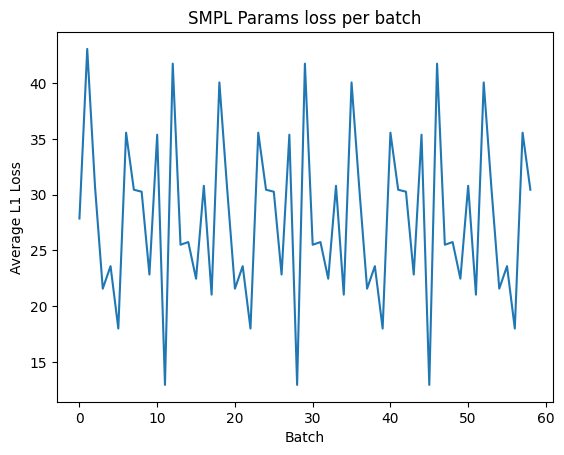

In [ ]:
import matplotlib.pyplot as plt
import time

print(batch_losses)

plt.title("SMPL Params loss per batch")
plt.xlabel("Batch")
plt.ylabel("Average L1 Loss")
plt.plot(np.arange(len(batch_losses)), batch_losses)

plt.savefig(f"Visualizations/multihmr_smpl_loss_per_batch_{time.time()}.png")

[30.524338834425983, 29.990439639371985, 29.990439639371985, 29.990439639371985, 29.990439639371985, 29.990439639371985, 29.990439639371985, 29.990439639371985, 29.990439639371985, 29.990439639371985]


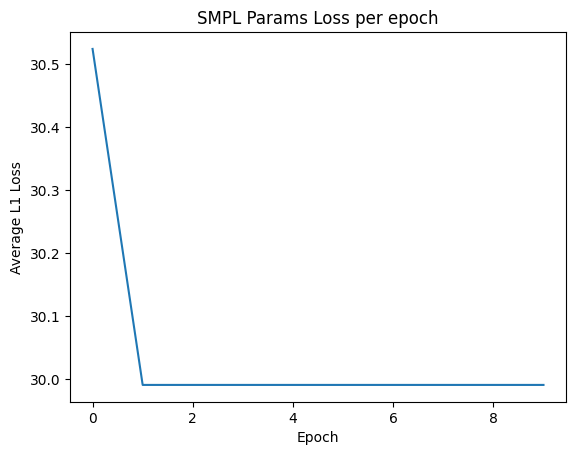

In [ ]:
import matplotlib.pyplot as plt

print(epoch_losses)

plt.title("SMPL Params Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average L1 Loss")
plt.plot(np.arange(len(epoch_losses)), epoch_losses)

plt.savefig(f"Visualizations/multihmr_smpl_loss_per_epoch_{time.time()}.png")